# Notebook Execution Guide

1. Activate the repo context (first code cell) to ensure `.venv` and `src/` imports.
2. Stage 1 (baseline/optimization) – run once per configuration.
3. Stage 2 (analysis and plots) – rerun freely after Stage 1 completes.
4. Stage 3 (exports or optional studies) – execute if you need derived artifacts.

Stick to Stage 1 before rerunning analysis when parameters change.


This notebook sweeps the number of CRAB basis functions for the transverse (K_omega) and detuning (K_delta) channels when optimizing the same GRAPE cost function with the ADAM optimizer.

We reuse the pulse shapes and penalties from earlier step-size experiments and collect per-run metrics (cost, runtime, gradient norms) to quantify how basis capacity changes convergence.

**Sweep definition**

- K_omega ? {4, 8, 16, 24}
- K_delta ? {0, 4, 8}
- Deterministic setup (no random seeds), 5 minute runtime budget, ADAM hyperparameters fixed across runs.

In [1]:
# === Imports (patched for WSL) ===
from pathlib import Path
import sys
from typing import Any, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Ensure repo root on sys.path ---
if "__file__" in globals():
    notebook_dir = Path(globals()["__file__"]).resolve().parent
else:
    notebook_dir = Path.cwd()

repo_root_guess = (
    notebook_dir.parent if notebook_dir.name == "notebooks" else notebook_dir
)
if str(repo_root_guess) not in map(str, sys.path):
    sys.path.insert(0, str(repo_root_guess))

# --- Safe activate_repository replacement ---
try:
    from src.notebook_setup import activate_repository
    repo_root = activate_repository(context=globals())
except Exception as e:
    print(f"[activate_repository skipped due to error: {e}]")
    repo_root = repo_root_guess

# --- Continue as before ---
from src import override_from_dict, run_experiment
from src.analysis.plots import save_figure
from src.notebook_runners import (
    build_base_config,
    method_options,
    prepare_baseline,
)
print("Imports complete — repo_root:", repo_root)


Imports complete — repo_root: /home/yehon/projects/grape-crab-qoc


In [2]:
# Experiment configuration inputs
# Baseline grid/shape parameters
time_grid_params = {
    'duration_us': 0.1,
    'num_points': 2001,
    'start_us': 0.0,
}
omega_shape = {'kind': 'polynomial', 'area_pi': 4.0}
delta_shape = {'kind': 'polynomial_chirp', 'area_pi': 0.0, 'amplitude_scale': 150.0}

# Basis sweep grid
K_OMEGA_VALUES = (1, 2, 4, 8, 16 , 24)
K_DELTA_VALUES = (0, 2, 4, 8, 16, 24)

# Focused subset for detailed plots
K_OMEGA_PLOT_VALUES = (4, 8, 16, 24)
K_DELTA_PLOT_VALUES = (0, 4, 8)

# Optional state / pulse seeds (set to None to use defaults)
rho0 = [[1.0, 0.0], [0.0, 0.0]]
target = [[0.0, 0.0], [0.0, 1.0]]
initial_omega = None
initial_delta = None

# Optimizer runtime and convergence controls
max_time_min = 5.0  # per optimization budget in minutes
max_iters = 2000
grad_tol = 1e-10
rtol = 1e-10

BASE_OPTIMIZER_COMMON = {
    'max_iters': int(max_iters),
    'grad_tol': float(grad_tol),
    'rtol': float(rtol),
    'max_time_s': float(max_time_min) * 60.0,
}

# ADAM hyperparameters (fixed across sweep)
adam_learning_rate = 0.05
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
lr_decay = 1.0

ADAM_OVERRIDES = {
    'learning_rate': float(adam_learning_rate),
    'beta1': float(beta1),
    'beta2': float(beta2),
    'epsilon': float(epsilon),
    'lr_decay': float(lr_decay),
}

# Stage 1 penalty weights
power_weight = 1.0e-5
neg_weight = 1.0e-8
neg_kappa = 10.0

PENALTIES = {
    'power_weight': float(power_weight),
    'neg_weight': float(neg_weight),
    'neg_kappa': float(neg_kappa),
}

# Artifact/output naming
artifact_root = Path('./artifacts')
run_name_base = 'basis-capacity'
export_subdir = 'basis_capacity_sweep'
objective = 'terminal'


# Execution order
# Stage 1: baseline + optimization (run once)
# Stage 2: analysis/plots (safe to rerun)
# Stage 3: exports (optional)

In [3]:
# Helper utilities
def extract_history_series(history: Dict[str, Any]) -> Dict[str, np.ndarray | None]:
    def _pull(key: str, dtype=float):
        series = history.get(key)
        if series is None:
            return None
        arr = np.asarray(series, dtype=dtype)
        return arr if arr.size else None

    return {
        'iter': _pull('iter', dtype=np.int64),
        'cost_total': _pull('total', dtype=float),
        'cost_terminal': _pull('terminal', dtype=float),
        'cost_power': _pull('power_penalty', dtype=float),
        'cost_neg': _pull('neg_penalty', dtype=float),
        'grad_norm': _pull('grad_norm', dtype=float),
        'step_norm': _pull('step_norm', dtype=float),
        'lr': _pull('lr', dtype=float),
        'calls_per_iter': _pull('calls_per_iter', dtype=np.int64),
    }


def summarize_adam_result(result) -> tuple[Dict[str, Any], Dict[str, np.ndarray | None]]:
    history_map = extract_history_series(result.history)
    total_series = history_map.get('cost_total')
    iterations = int(total_series.size) if total_series is not None else 0

    grad_series = history_map.get('grad_norm')
    grad_final = float(grad_series[-1]) if grad_series is not None and grad_series.size else float('nan')
    step_series = history_map.get('step_norm')
    step_final = float(step_series[-1]) if step_series is not None and step_series.size else float('nan')
    calls_series = history_map.get('calls_per_iter')
    oracle_calls = int(np.asarray(calls_series, dtype=np.int64).sum()) if calls_series is not None else 0

    metrics = result.final_metrics
    pulses = result.pulses
    omega_final = np.asarray(pulses.get('omega'), dtype=np.float64)
    t_us = np.asarray(pulses.get('t_us'), dtype=np.float64)

    summary = {
        'total_final': float(metrics.get('total', np.nan)),
        'terminal_final': float(metrics.get('terminal', np.nan)),
        'power_final': float(metrics.get('power_penalty', 0.0)),
        'neg_final': float(metrics.get('neg_penalty', 0.0)),
        'runtime_s': float(metrics.get('runtime_s', np.nan)),
        'iterations': iterations,
        'grad_norm_final': grad_final,
        'step_norm_final': step_final,
        'oracle_calls': oracle_calls,
        'max_abs_omega': float(np.max(np.abs(omega_final))) if omega_final.size else float('nan'),
        'area_omega_over_pi': float(np.trapezoid(np.abs(omega_final), t_us) / np.pi) if omega_final.size and t_us.size else float('nan'),
        'negativity_fraction': float(np.mean(omega_final < 0.0)) if omega_final.size else float('nan'),
        'run_name': result.run_name,
        'artifacts_dir': str(result.artifacts_dir),
    }

    status_info = result.optimizer_state or {}
    status = str(status_info.get('status', 'unknown'))
    summary['status'] = status
    summary['status_detail'] = status
    return summary, history_map


In [4]:
# Run ADAM sweep over (K_omega, K_delta) pairs
sweep_records: list[Dict[str, Any]] = []
history_by_basis: Dict[Tuple[int, int], Dict[str, np.ndarray | None]] = {}
pulses_by_basis: Dict[Tuple[int, int], Dict[str, np.ndarray]] = {}

for K_omega in K_OMEGA_VALUES:
    for K_delta in K_DELTA_VALUES:
        run_label = f'{run_name_base}-Ko{K_omega:02d}-Kd{K_delta:02d}'
        print(f"[adam][Ko={K_omega:02d} Kd={K_delta:02d}] starting optimization")

        ctx = prepare_baseline(
            time_grid=time_grid_params,
            omega_shape=omega_shape,
            delta_shape=delta_shape,  # preserve baseline detuning even when K_delta=0
            K_omega=int(K_omega),
            K_delta=int(K_delta),
            rho0=rho0,
            target=target,
            initial_omega=initial_omega,
            initial_delta=initial_delta,
        )

        base_opts = dict(BASE_OPTIMIZER_COMMON)
        base_opts['optimize_delta'] = bool(K_delta > 0)

        base_config, base_options = build_base_config(
            ctx.config,
            run_name=run_label,
            artifact_root=artifact_root,
            penalties=PENALTIES,
            objective=objective,
            base_optimizer_options=base_opts,
        )

        adam_options = method_options('adam', base_options, ADAM_OVERRIDES)
        config = override_from_dict(base_config, {'optimizer_options': adam_options})

        result = run_experiment(
            config,
            method='adam',
            run_name=run_label,
            exist_ok=True,
        )

        summary, history_map = summarize_adam_result(result)
        summary['K_omega'] = int(K_omega)
        summary['K_delta'] = int(K_delta)
        sweep_records.append(summary)
        history_by_basis[(int(K_omega), int(K_delta))] = history_map
        pulses_by_basis[(int(K_omega), int(K_delta))] = {
            'omega': np.asarray(result.pulses.get('omega'), dtype=np.float64),
            'delta': None if result.pulses.get('delta') is None else np.asarray(result.pulses.get('delta'), dtype=np.float64),
            't_us': np.asarray(result.pulses.get('t_us'), dtype=np.float64),
        }

        print(f"[adam][Ko={K_omega:02d} Kd={K_delta:02d}] finished (status={summary['status']})")


[adam][Ko=01 Kd=00] starting optimization
[adam][Ko=01 Kd=00] finished (status=converged_rtol)
[adam][Ko=01 Kd=02] starting optimization
[adam][Ko=01 Kd=02] finished (status=max_iters)
[adam][Ko=01 Kd=04] starting optimization
[adam][Ko=01 Kd=04] finished (status=max_iters)
[adam][Ko=01 Kd=08] starting optimization
[adam][Ko=01 Kd=08] finished (status=max_iters)
[adam][Ko=01 Kd=16] starting optimization
[adam][Ko=01 Kd=16] finished (status=max_iters)
[adam][Ko=01 Kd=24] starting optimization
[adam][Ko=01 Kd=24] finished (status=max_iters)
[adam][Ko=02 Kd=00] starting optimization
[adam][Ko=02 Kd=00] finished (status=converged_rtol)
[adam][Ko=02 Kd=02] starting optimization
[adam][Ko=02 Kd=02] finished (status=max_iters)
[adam][Ko=02 Kd=04] starting optimization
[adam][Ko=02 Kd=04] finished (status=max_iters)
[adam][Ko=02 Kd=08] starting optimization
[adam][Ko=02 Kd=08] finished (status=max_iters)
[adam][Ko=02 Kd=16] starting optimization
[adam][Ko=02 Kd=16] finished (status=max_iters)


In [5]:
# Compile summary table
summary_df = pd.DataFrame(sweep_records)
if not summary_df.empty:
    ordered_columns = [
        'K_omega',
        'K_delta',
        'status',
        'total_final',
        'terminal_final',
        'runtime_s',
        'iterations',
        'grad_norm_final',
        'step_norm_final',
        'oracle_calls',
        'max_abs_omega',
        'area_omega_over_pi',
        'negativity_fraction',
        'run_name',
        'artifacts_dir',
    ]
    available_columns = [col for col in ordered_columns if col in summary_df.columns]
    summary_df = summary_df[available_columns].sort_values(['K_delta', 'K_omega']).reset_index(drop=True)
summary_df


,K_omega,K_delta,status,total_final,terminal_final,runtime_s,iterations,grad_norm_final,step_norm_final,oracle_calls,max_abs_omega,area_omega_over_pi,negativity_fraction,run_name,artifacts_dir
0,1,0,converged_rtol,0.036007,2.018030e-05,13.999558,378,2.176079e-07,0.000000,378,216.210085,4.667717,0.000000,basis-capacity-Ko01-Kd00,artifacts/basis-capacity-Ko01-Kd00
1,2,0,converged_rtol,0.036007,2.019516e-05,20.016904,505,4.773134e-07,0.000000,505,216.210063,4.667715,0.000000,basis-capacity-Ko02-Kd00,artifacts/basis-capacity-Ko02-Kd00
2,4,0,max_iters,0.033663,6.577695e-06,74.714675,2000,2.786742e-04,0.007638,2000,270.197356,4.325601,0.000000,basis-capacity-Ko04-Kd00,artifacts/basis-capacity-Ko04-Kd00
3,8,0,max_iters,0.023037,5.649019e-06,74.313544,2000,5.920156e-04,0.050171,2000,192.060759,3.443423,0.000000,basis-capacity-Ko08-Kd00,artifacts/basis-capacity-Ko08-Kd00
4,16,0,max_iters,0.044190,2.391693e-06,75.241552,2000,1.169761e-04,0.013527,2000,376.817845,4.165696,0.121939,basis-capacity-Ko16-Kd00,artifacts/basis-capacity-Ko16-Kd00
5,24,0,max_iters,0.049547,1.019665e-06,81.160073,2000,2.370034e-04,0.029532,2000,498.560670,4.320117,0.167416,basis-capacity-Ko24-Kd00,artifacts/basis-capacity-Ko24-Kd00
6,1,2,max_iters,0.036214,3.513402e-05,73.276432,2000,5.366204e-06,0.000106,2000,206.541003,4.471780,0.000000,basis-capacity-Ko01-Kd02,artifacts/basis-capacity-Ko01-Kd02
7,2,2,max_iters,0.036227,3.605456e-05,76.811460,2000,7.431958e-06,0.000912,2000,206.185408,4.461470,0.000000,basis-capacity-Ko02-Kd02,artifacts/basis-capacity-Ko02-Kd02
8,4,2,max_iters,0.032558,1.117350e-05,78.043210,2000,3.489343e-04,0.008182,2000,264.611641,4.060562,0.000000,basis-capacity-Ko04-Kd02,artifacts/basis-capacity-Ko04-Kd02
9,8,2,max_iters,0.022479,2.243112e-06,78.242451,2000,5.435386e-04,0.029382,2000,220.275621,3.345885,0.000000,basis-capacity-Ko08-Kd02,artifacts/basis-capacity-Ko08-Kd02


Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/figures/terminal_cost_heatmap.png


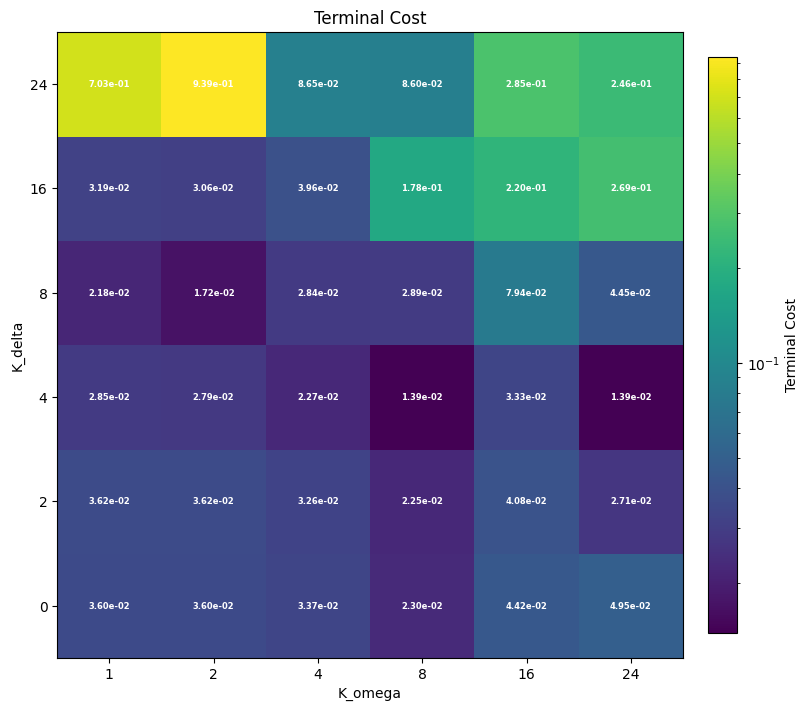

In [6]:
from matplotlib.colors import LogNorm
# Heatmaps for terminal infidelity and runtime
if not summary_df.empty:
    pivot_terminal = summary_df.pivot(index='K_delta', columns='K_omega', values='total_final')

    fig_dir = (artifact_root / export_subdir / 'figures').resolve()
    fig_dir.mkdir(parents=True, exist_ok=True)

    fig, axes = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
    ims = [
        axes.imshow(
            pivot_terminal.values,
            norm=LogNorm(vmin=pivot_terminal.values.min(), vmax=pivot_terminal.values.max()),
            origin='lower',
            cmap='viridis',
        ),
    ]
    axes.set_title('Terminal Cost')

    axes.set_xticks(range(pivot_terminal.shape[1]))
    axes.set_xticklabels(pivot_terminal.columns)
    axes.set_yticks(range(pivot_terminal.shape[0]))
    axes.set_yticklabels(pivot_terminal.index)
    axes.set_xlabel('K_omega')
    axes.set_ylabel('K_delta')
    for (i, j), value in np.ndenumerate(pivot_terminal.values):
        axes.text(j, i, f"{value:.2e}", ha='center', va='center', color='white', fontsize=6, fontweight='bold')

    fig.colorbar(ims[0], ax=axes, fraction=0.046, pad=0.04, label='Terminal Cost')

    stem = 'terminal_cost_heatmap'
    save_figure(fig, fig_dir, stem, save_svg=True)
    print(f"Saved figure: {fig_dir / (stem + '.png')}")
    plt.show()


Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/figures/total_cost_vs_iter_focused.png


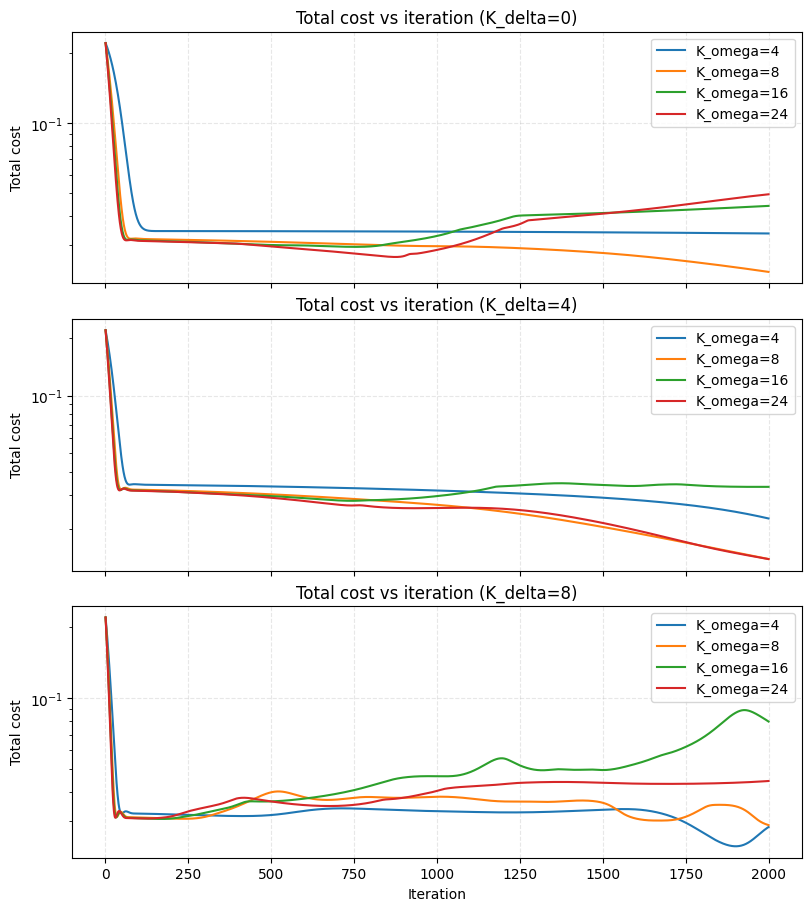

In [7]:
# Cost trajectories grouped by K_delta
if history_by_basis:
    plot_delta_values = []
    for K_delta in K_DELTA_PLOT_VALUES:
        if K_delta not in K_DELTA_VALUES:
            continue
        for K_omega in K_OMEGA_PLOT_VALUES:
            history = history_by_basis.get((K_omega, K_delta))
            if not history:
                continue
            total_series = history.get('cost_total')
            if total_series is None:
                continue
            total_series = np.asarray(total_series)
            if total_series.size == 0:
                continue
            plot_delta_values.append(K_delta)
            break
    if not plot_delta_values:
        print('No matching K_delta entries found for the focused cost plots.')
    else:
        fig, axes = plt.subplots(len(plot_delta_values), 1, figsize=(8, 3 * len(plot_delta_values)), sharex=True, constrained_layout=True)
        if len(plot_delta_values) == 1:
            axes = [axes]
        for idx, K_delta in enumerate(plot_delta_values):
            ax = axes[idx]
            for K_omega in K_OMEGA_PLOT_VALUES:
                history = history_by_basis.get((K_omega, K_delta))
                if not history:
                    continue
                total_series = history.get('cost_total')
                if total_series is None:
                    continue
                total_series = np.asarray(total_series)
                if total_series.size == 0:
                    continue
                iter_series = history.get('iter')
                if iter_series is not None:
                    iter_series = np.asarray(iter_series)
                x_axis = iter_series if iter_series is not None and getattr(iter_series, 'size', 0) == total_series.size else np.arange(total_series.size)
                ax.plot(x_axis, total_series, label=f'K_omega={K_omega}')
            ax.set_title(f'Total cost vs iteration (K_delta={K_delta})')
            ax.set_ylabel('Total cost')
            ax.set_yscale('log')
            ax.grid(True, linestyle='--', alpha=0.3)
            if ax.lines:
                ax.legend()
        axes[-1].set_xlabel('Iteration')

        fig_dir = (artifact_root / export_subdir / 'figures').resolve()
        fig_dir.mkdir(parents=True, exist_ok=True)
        stem = 'total_cost_vs_iter_focused'
        save_figure(fig, fig_dir, stem, save_svg=True)
        print(f"Saved figure: {fig_dir / (stem + '.png')}")
        plt.show()


## Pulse Comparisons

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/figures/omega_waveforms_Kd00.png


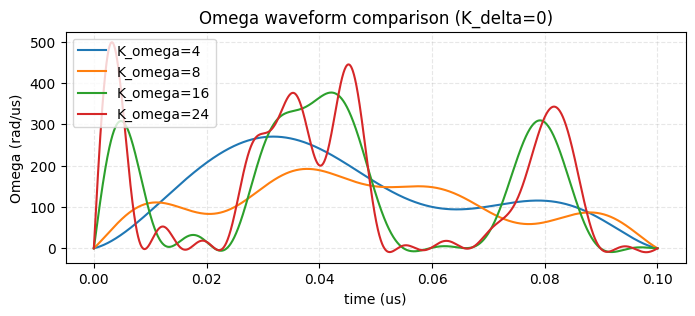

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/figures/omega_waveforms_Kd04.png


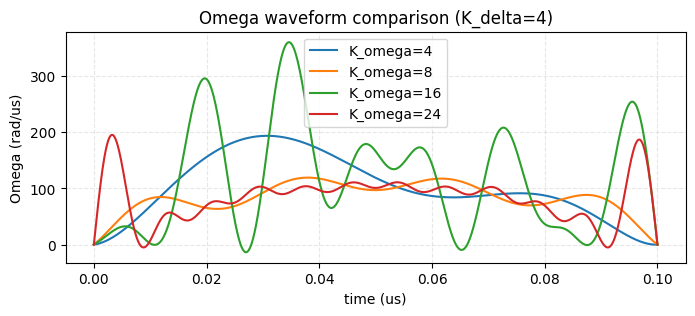

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/figures/omega_waveforms_Kd08.png


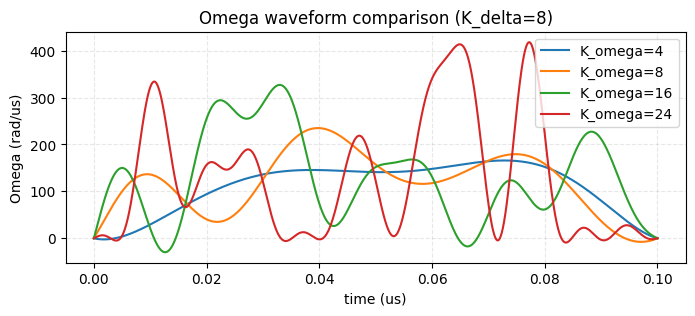

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/figures/delta_waveforms_Ko04.png


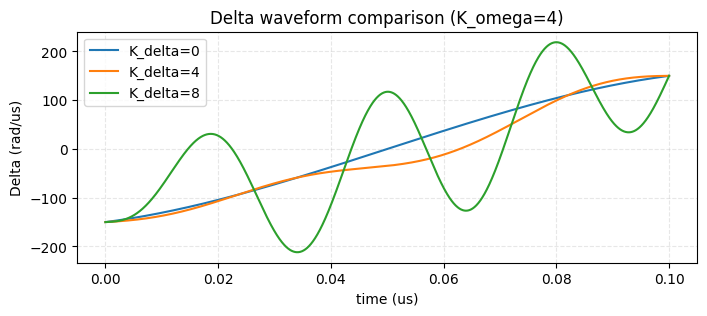

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/figures/delta_waveforms_Ko08.png


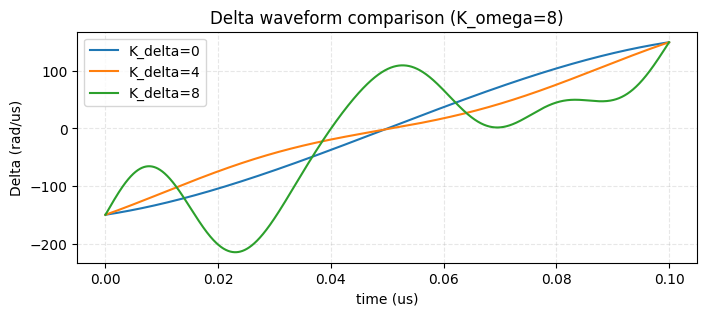

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/figures/delta_waveforms_Ko16.png


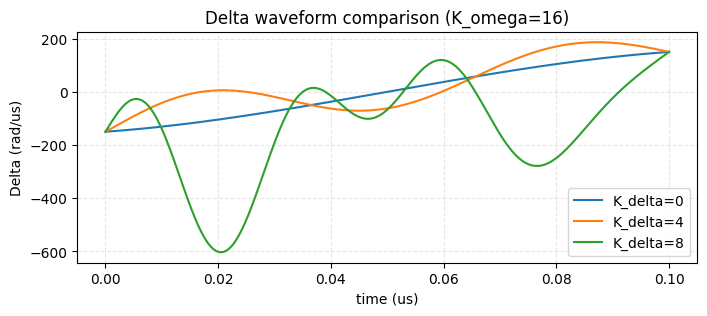

Saved figure: /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/figures/delta_waveforms_Ko24.png


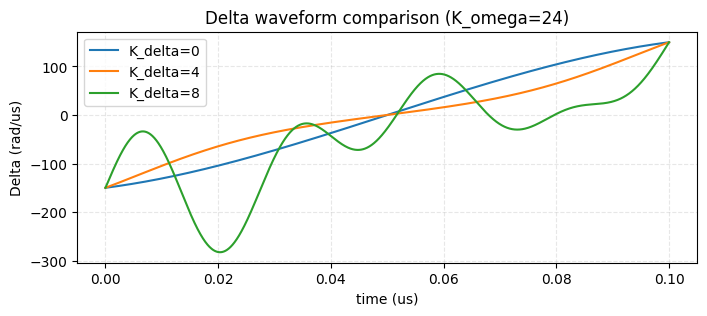

In [8]:
# Compare optimized pulses across basis sizes
fig_dir = (artifact_root / export_subdir / 'figures').resolve()
if not pulses_by_basis:
    print('Run the sweep above before plotting pulses.')
else:
    fig_dir.mkdir(parents=True, exist_ok=True)
    plot_delta_values = []
    for K_delta in K_DELTA_PLOT_VALUES:
        if K_delta not in K_DELTA_VALUES:
            continue
        for K_omega in K_OMEGA_PLOT_VALUES:
            pulses = pulses_by_basis.get((K_omega, K_delta))
            if not pulses:
                continue
            omega = pulses.get('omega')
            if omega is None:
                continue
            omega = np.asarray(omega)
            if omega.size == 0:
                continue
            plot_delta_values.append(K_delta)
            break
    if not plot_delta_values:
        print('No Omega waveforms available for the focused subset.')
    else:
        for K_delta in plot_delta_values:
            fig, ax = plt.subplots(figsize=(8, 3))
            for K_omega in K_OMEGA_PLOT_VALUES:
                pulses = pulses_by_basis.get((K_omega, K_delta))
                if not pulses:
                    continue
                t_us = pulses.get('t_us')
                omega = pulses.get('omega')
                if t_us is None or omega is None:
                    continue
                t_us = np.asarray(t_us)
                omega = np.asarray(omega)
                if t_us.size == 0 or omega.size == 0:
                    continue
                ax.plot(t_us, omega, label=f'K_omega={K_omega}')
            if not ax.lines:
                plt.close(fig)
                continue
            ax.set_title(f'Omega waveform comparison (K_delta={K_delta})')
            ax.set_xlabel('time (us)')
            ax.set_ylabel('Omega (rad/us)')
            ax.grid(True, linestyle='--', alpha=0.3)
            ax.legend()
            stem = f'omega_waveforms_Kd{K_delta:02d}'
            save_figure(fig, fig_dir, stem, save_svg=True)
            print(f"Saved figure: {fig_dir / (stem + '.png')}")
            plt.show()

    subset_has_delta = False
    for K_omega in K_OMEGA_PLOT_VALUES:
        for K_delta in K_DELTA_PLOT_VALUES:
            pulses = pulses_by_basis.get((K_omega, K_delta))
            if not pulses:
                continue
            delta = pulses.get('delta')
            t_us = pulses.get('t_us')
            if t_us is None or delta is None:
                continue
            delta = np.asarray(delta)
            t_us = np.asarray(t_us)
            if delta.size == 0 or t_us.size == 0:
                continue
            subset_has_delta = True
            break
        if subset_has_delta:
            break

    global_has_delta = any(
        (p.get('delta') is not None and np.asarray(p.get('delta')).size > 0)
        for p in pulses_by_basis.values()
    )

    if subset_has_delta:
        plot_omega_values = []
        for K_omega in K_OMEGA_PLOT_VALUES:
            for K_delta in K_DELTA_PLOT_VALUES:
                pulses = pulses_by_basis.get((K_omega, K_delta))
                if not pulses:
                    continue
                t_us = pulses.get('t_us')
                delta = pulses.get('delta')
                if t_us is None or delta is None:
                    continue
                t_us = np.asarray(t_us)
                delta = np.asarray(delta)
                if t_us.size == 0 or delta.size == 0:
                    continue
                plot_omega_values.append(K_omega)
                break
        if not plot_omega_values:
            print('Detuning waveforms were available but lacked time grids in the focused subset.')
        else:
            for K_omega in plot_omega_values:
                fig, ax = plt.subplots(figsize=(8, 3))
                for K_delta in K_DELTA_PLOT_VALUES:
                    pulses = pulses_by_basis.get((K_omega, K_delta))
                    if not pulses:
                        continue
                    t_us = pulses.get('t_us')
                    delta = pulses.get('delta')
                    if t_us is None or delta is None:
                        continue
                    t_us = np.asarray(t_us)
                    delta = np.asarray(delta)
                    if t_us.size == 0 or delta.size == 0:
                        continue
                    ax.plot(t_us, delta, label=f'K_delta={K_delta}')
                if not ax.lines:
                    plt.close(fig)
                    continue
                ax.set_title(f'Delta waveform comparison (K_omega={K_omega})')
                ax.set_xlabel('time (us)')
                ax.set_ylabel('Delta (rad/us)')
                ax.grid(True, linestyle='--', alpha=0.3)
                ax.legend()
                stem = f'delta_waveforms_Ko{K_omega:02d}'
                save_figure(fig, fig_dir, stem, save_svg=True)
                print(f"Saved figure: {fig_dir / (stem + '.png')}")
                plt.show()
    elif global_has_delta:
        print('Detuning waveforms were generated only outside the focused subset.')
    else:
        print('No detuning waveforms were optimized (all K_delta = 0).')


## Aggregated Metrics

In [9]:
# Summaries grouped by basis size
if summary_df.empty:
    print('Run the sweep above before computing aggregates.')
else:
    metrics_cols = ['total_final', 'terminal_final', 'runtime_s']
    stats_by_delta = summary_df.groupby('K_delta')[metrics_cols].agg(['mean', 'min', 'max'])
    stats_by_omega = summary_df.groupby('K_omega')[metrics_cols].agg(['mean', 'min', 'max'])
    print('Aggregated metrics by K_delta:')
    print(stats_by_delta.round(6))
    print('Aggregated metrics by K_omega:')
    print(stats_by_omega.round(6))

Aggregated metrics by K_delta:
        total_final                     terminal_final                      \
               mean       min       max           mean       min       max   
K_delta                                                                      
0          0.037075  0.023037  0.049547       0.000009  0.000001  0.000020   
2          0.032576  0.022479  0.040843       0.000014  0.000000  0.000036   
4          0.023354  0.013894  0.033254       0.000002  0.000000  0.000005   
8          0.036670  0.017166  0.079351       0.000001  0.000001  0.000002   
16         0.128087  0.030634  0.268549       0.000003  0.000001  0.000005   
24         0.390972  0.085982  0.939289       0.000007  0.000000  0.000021   

         runtime_s                        
              mean        min        max  
K_delta                                   
0        56.574384  13.999558  81.160073  
2        77.763886  73.276432  81.208853  
4        76.078896  74.132812  81.728552  
8       

## Export Summaries

In [10]:
# Persist tabular data for reuse
if summary_df.empty:
    print('Run the sweep above before exporting summary tables.')
else:
    export_dir = (artifact_root / export_subdir).resolve()
    export_dir.mkdir(parents=True, exist_ok=True)
    csv_path = export_dir / 'summary.csv'
    json_path = export_dir / 'summary.json'
    summary_df.to_csv(csv_path, index=False)
    summary_df.to_json(json_path, orient='records', indent=2)
    print(f'Wrote {csv_path}')
    print(f'Wrote {json_path}')

Wrote /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/summary.csv
Wrote /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/summary.json


## Further Exploration

- Extend robustness analysis by activating ensemble objectives or noise sweeps.
- Experiment with adaptive basis schedules (for example, increase K_omega during optimization).
- Integrate these results into reporting or automation once the sweep stabilizes.